# 🧵 Uncovering Customer Insights with Word Embeddings

Hey! Welcome to my deep dive into customer sentiment and feedback analysis using **word embeddings**. For this project, I explored the **Women's Clothing E-Commerce Reviews** dataset, with a focus on the `"Review Text"` column — a goldmine of authentic customer opinions about product fit, comfort, quality, and style.

## 🎯 Project Objective

The main goal was to **transform raw customer feedback into structured insights** using **OpenAI’s `text-embedding-ada-002` model**. Here's a breakdown of what I set out to do:

- **Generate embeddings** for each review text using OpenAI's API.
- **Visualize** the semantic structure of reviews using **t-SNE**.
- **Categorize reviews** into predefined themes like *Quality*, *Fit*, *Style*, and *Comfort* based on embedding similarity.
- **Search for similar reviews** using a **vector database (ChromaDB)** to power semantic search.

## 🧠 Tools & Techniques

Here's a quick overview of the stack I used:

- **OpenAI Embeddings API** – to convert textual data into vector representations
- **t-SNE (from Scikit-learn)** – to reduce high-dimensional embeddings into 2D for visualization
- **ChromaDB** – for persistent vector storage and fast similarity search
- **SciPy (Cosine Distance)** – to compare reviews against category vectors

## 📊 Visualizing Review Themes

Using t-SNE, I visualized the high-dimensional relationships between customer reviews. This helped reveal clusters of feedback with similar semantic meanings — from customers raving about quality to those frustrated by fit.

## 🗂️ Categorizing Feedback

Each review was compared against embedding vectors of core themes (Quality, Fit, Style, Comfort). Using cosine similarity, reviews were automatically assigned to the most relevant category — a great first step toward automated feedback analysis.

## 🔍 Finding Similar Reviews

I integrated **ChromaDB** to store the review embeddings and perform **semantic similarity search**. With just one query (e.g., _"Absolutely wonderful - silky and sexy and comfortable"_), the system returns the most semantically similar reviews from the dataset.

## 📁 The Dataset

Here's the key data field used in this project:

### womens_clothing_e-commerce_reviews.csv

| Column         | Description                                                                 |
|----------------|-----------------------------------------------------------------------------|
| `'Review Text'` | Textual feedback from customers about their shopping experience and product quality |

---

This project was a hands-on journey through the power of **language embeddings** in understanding customer sentiment. The combination of vector search, dimensionality reduction, and semantic classification turned unstructured text into actionable insights.

Let’s keep building smarter systems that actually understand what people are saying. Thanks for reading!

<center><img src="images/clothing.jpg" alt="Clothing Banner"></center>


## Load OpenAI API key from environment variables
These variables can be referenced globally throughout the project while keeping their values secret. Good for setting passwords in credentials.

## Install useful libraries

In [15]:
# Update OpenAI to 1.3
from importlib.metadata import version
try:
    assert version('openai') == '1.3.0'
except:
    !pip install openai==1.3.0
import openai

In [16]:
# Run this cell to install ChromaDB if desired
try:
    assert version('chromadb') == '0.4.17'
except:
    !pip install chromadb==0.4.17
try:
    assert version('pysqlite3') == '0.5.2'
except:
    !pip install pysqlite3-binary==0.5.2
__import__('pysqlite3')
import sys
sys.modules['sqlite3'] = sys.modules.pop('pysqlite3')
import chromadb

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [18]:
# # Import required libraries
import os
openai_api_key = os.environ["OPENAI_API_KEY"] #Api ey
import openai
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import chromadb
from scipy.spatial import distance
from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction

## Load the dataset
Load data and perform basic data checks to ensure you are using relevant data for the analysis

In [19]:
# Load the dataset
import pandas as pd
reviews = pd.read_csv("womens_clothing_e-commerce_reviews.csv")

# Display the first few entries
reviews.head()

review_texts = reviews["Review Text"].dropna()
print(reviews.describe())

         Review ID  Clothing ID  ...  Recommended IND  Positive Feedback Count
count  1000.000000  1000.000000  ...      1000.000000              1000.000000
mean    499.500000   910.282000  ...         0.818000                 2.614000
std     288.819436   198.919762  ...         0.386038                 5.700131
min       0.000000     2.000000  ...         0.000000                 0.000000
25%     249.750000   850.000000  ...         1.000000                 0.000000
50%     499.500000   907.000000  ...         1.000000                 1.000000
75%     749.250000  1060.000000  ...         1.000000                 3.000000
max     999.000000  1196.000000  ...         1.000000                84.000000

[8 rows x 6 columns]


In [12]:
# Start coding here
# Use as many cells as you need.

EMBEDDING_MODEL = "text-embedding-ada-002"

In [13]:
# Create and store the embeddings for reviews in one API call
client = openai.OpenAI(api_key=openai_api_key)
responses = client.embeddings.create(input = review_texts.tolist(), model = EMBEDDING_MODEL).model_dump()
embeddings = [response["embedding"] for response in responses["data"]]

In [20]:
# Apply t-SNE for dimensionality reduction
def apply_tsne(embeddings):
    tsne = TSNE(n_components=2, random_state=0)
    return tsne.fit_transform(embeddings)

embeddings_2d = apply_tsne(np.array(embeddings))

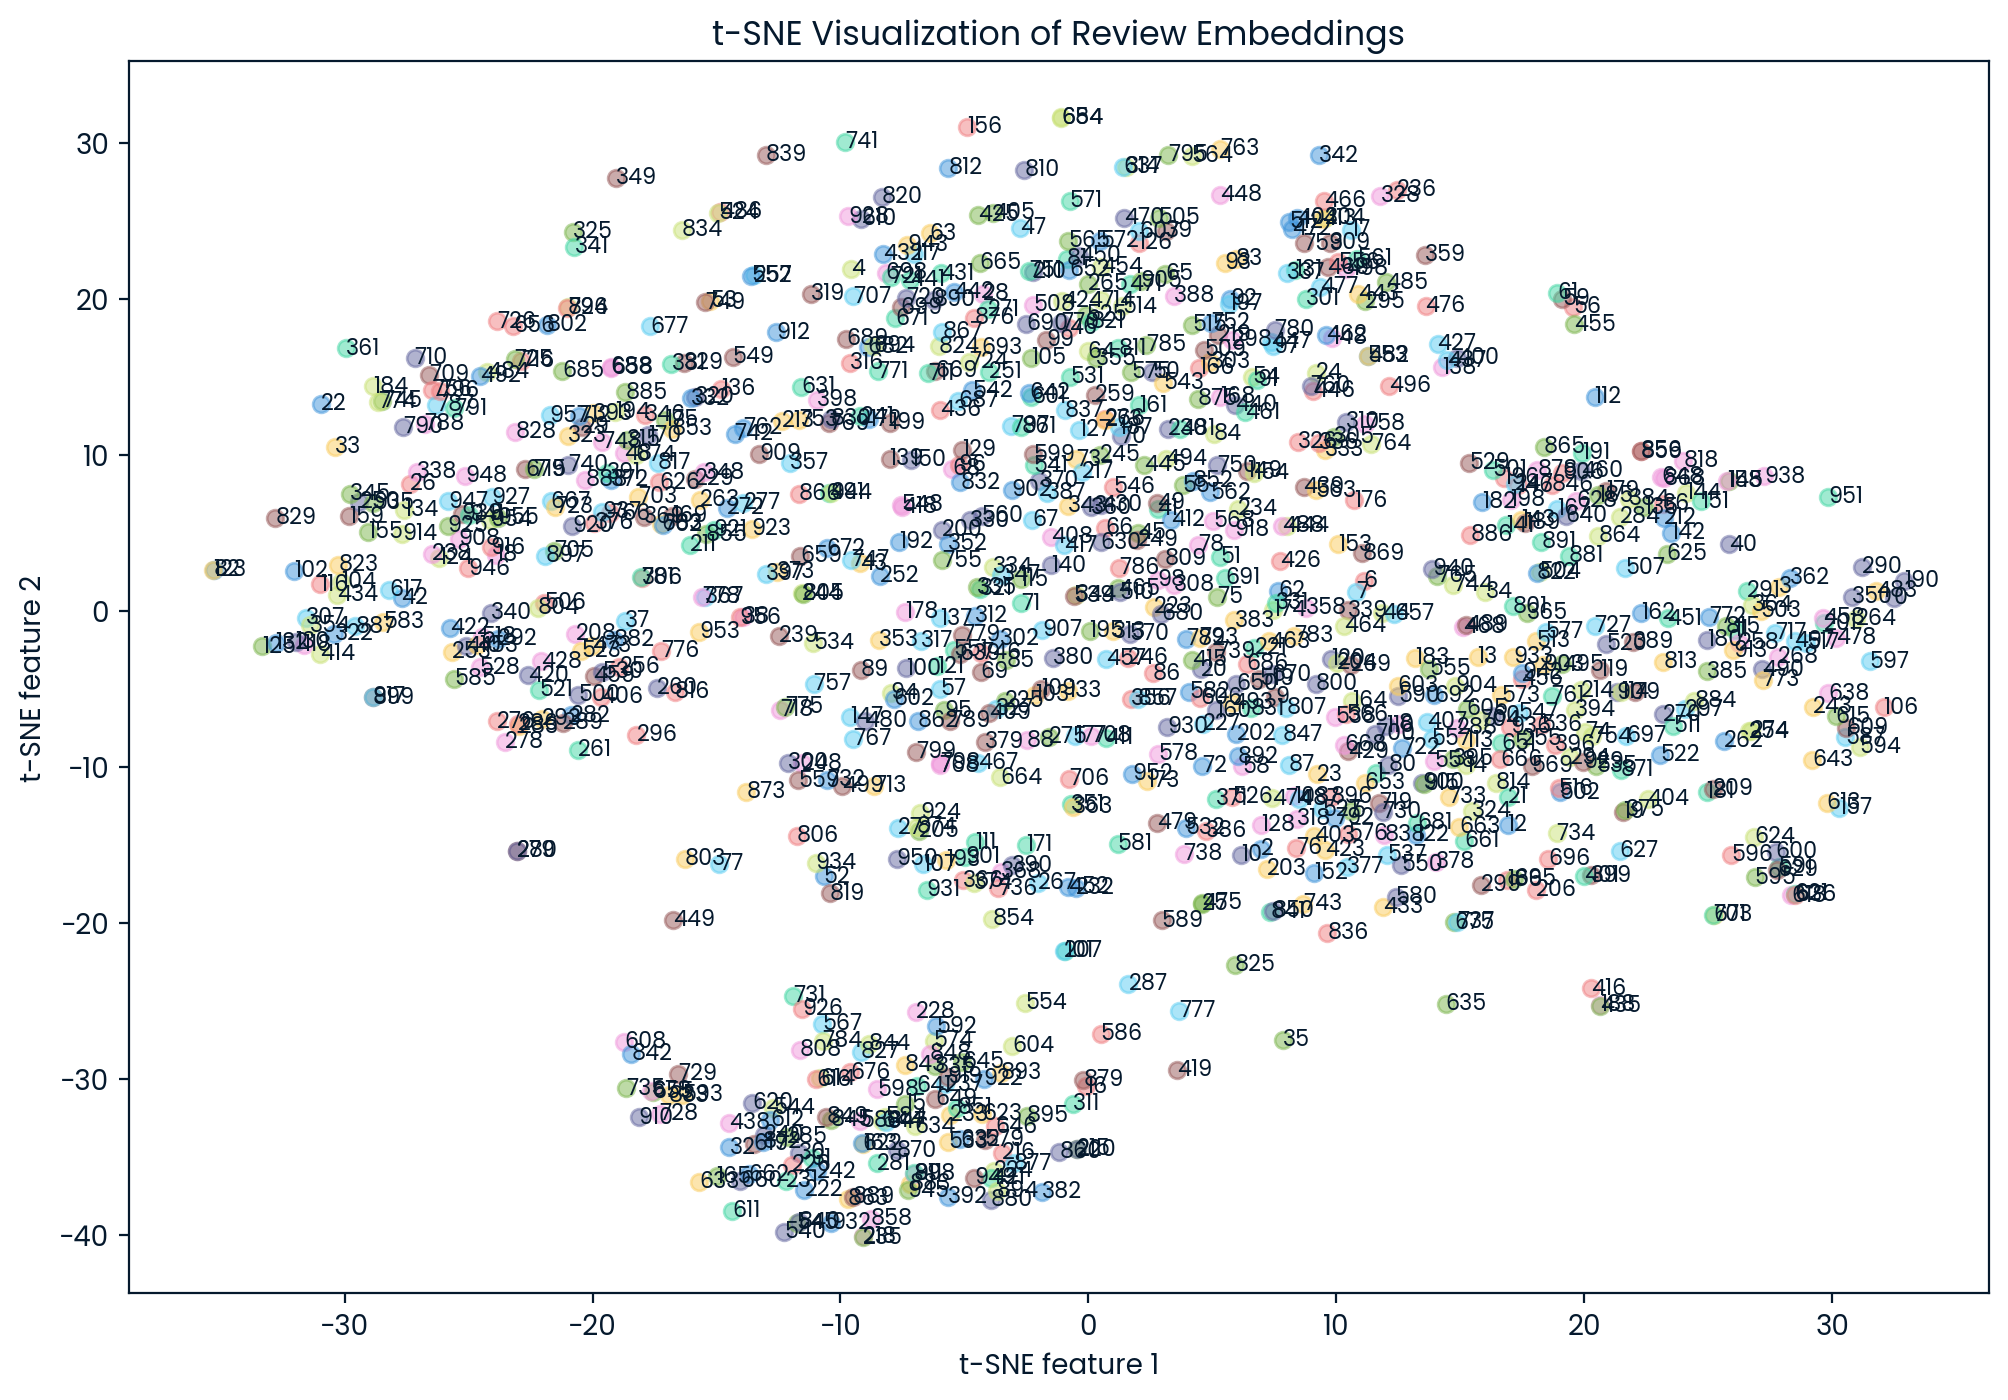

In [21]:
# Plotting the results of t-SNE
def plot_tsne(tsne_results):
    plt.figure(figsize=(12, 8))
    for i, point in enumerate(tsne_results):
        plt.scatter(point[0], point[1], alpha=0.5)
        plt.text(point[0], point[1], str(i), fontsize=8, verticalalignment='center')
    plt.title("t-SNE Visualization of Review Embeddings")
    plt.xlabel("t-SNE feature 1")
    plt.ylabel("t-SNE feature 2")
    plt.show()


#function call to plot the embedding
plot_tsne(embeddings_2d)

In [22]:
# Define topics
categories = ["Quality", "Fit", "Style", "Comfort"]

In [25]:
# Create embeddings for all categories in one API call
category_responses = client.embeddings.create(input=categories, model=EMBEDDING_MODEL).model_dump()

# Extract embeddings from the responses and map them to their respective categories
category_embeddings = [embedding["embedding"] for embedding in category_responses["data"]]
# print(category_embeddings)

In [28]:
# Function to categorize feedback
def categorize_feedback(text_embedding, category_embeddings):
    similarities = [{"distance": distance.cosine(text_embedding, cat_emb), "index":i}
                     for i, cat_emb in enumerate(category_embeddings)]
    closest = min(similarities, key=lambda x: x["index"])
    return categories[closest["index"]]

# Categorize feedback
feedback_categories = [categorize_feedback(embedding, category_embeddings) for embedding in embeddings]

In [29]:
# Initialize Chromadb instance for vector storage

client = chromadb.PersistentClient()

In [30]:
# Define vector database
review_embeddings_db = client.create_collection(
    name="review_embeddings",
    embedding_function=OpenAIEmbeddingFunction(api_key=openai_api_key))


In [31]:
# Store embeddings inside vector database
review_embeddings_db.add(
    documents=review_texts.tolist(),
    ids=[str(i) for i in range(len(review_texts))]
)


In [34]:
# Function for similarity search using vector db query function
def find_similar_reviews(input_text, vector_db, n=3):
    collection = client.get_collection(
        name="review_embeddings",
        embedding_function=OpenAIEmbeddingFunction(api_key=openai_api_key))
    results = collection.query(
        query_texts=[input_text],
        n_results=n
    )
    return results

In [35]:
# Example feedback and finding similar feedback
example_review = "Absolutely wonderful - silky and sexy and comfortable"
most_similar_reviews = find_similar_reviews(example_review, review_embeddings_db, 3)["documents"][0]
print(most_similar_reviews)

['Absolutely wonderful - silky and sexy and comfortable', 'Very comfortable and versatile. got lots of compliments.', 'Very comfortable, material is good, cut out on sleeves flattering']


In [36]:
# Clean up
client.delete_collection(name="review_embeddings")

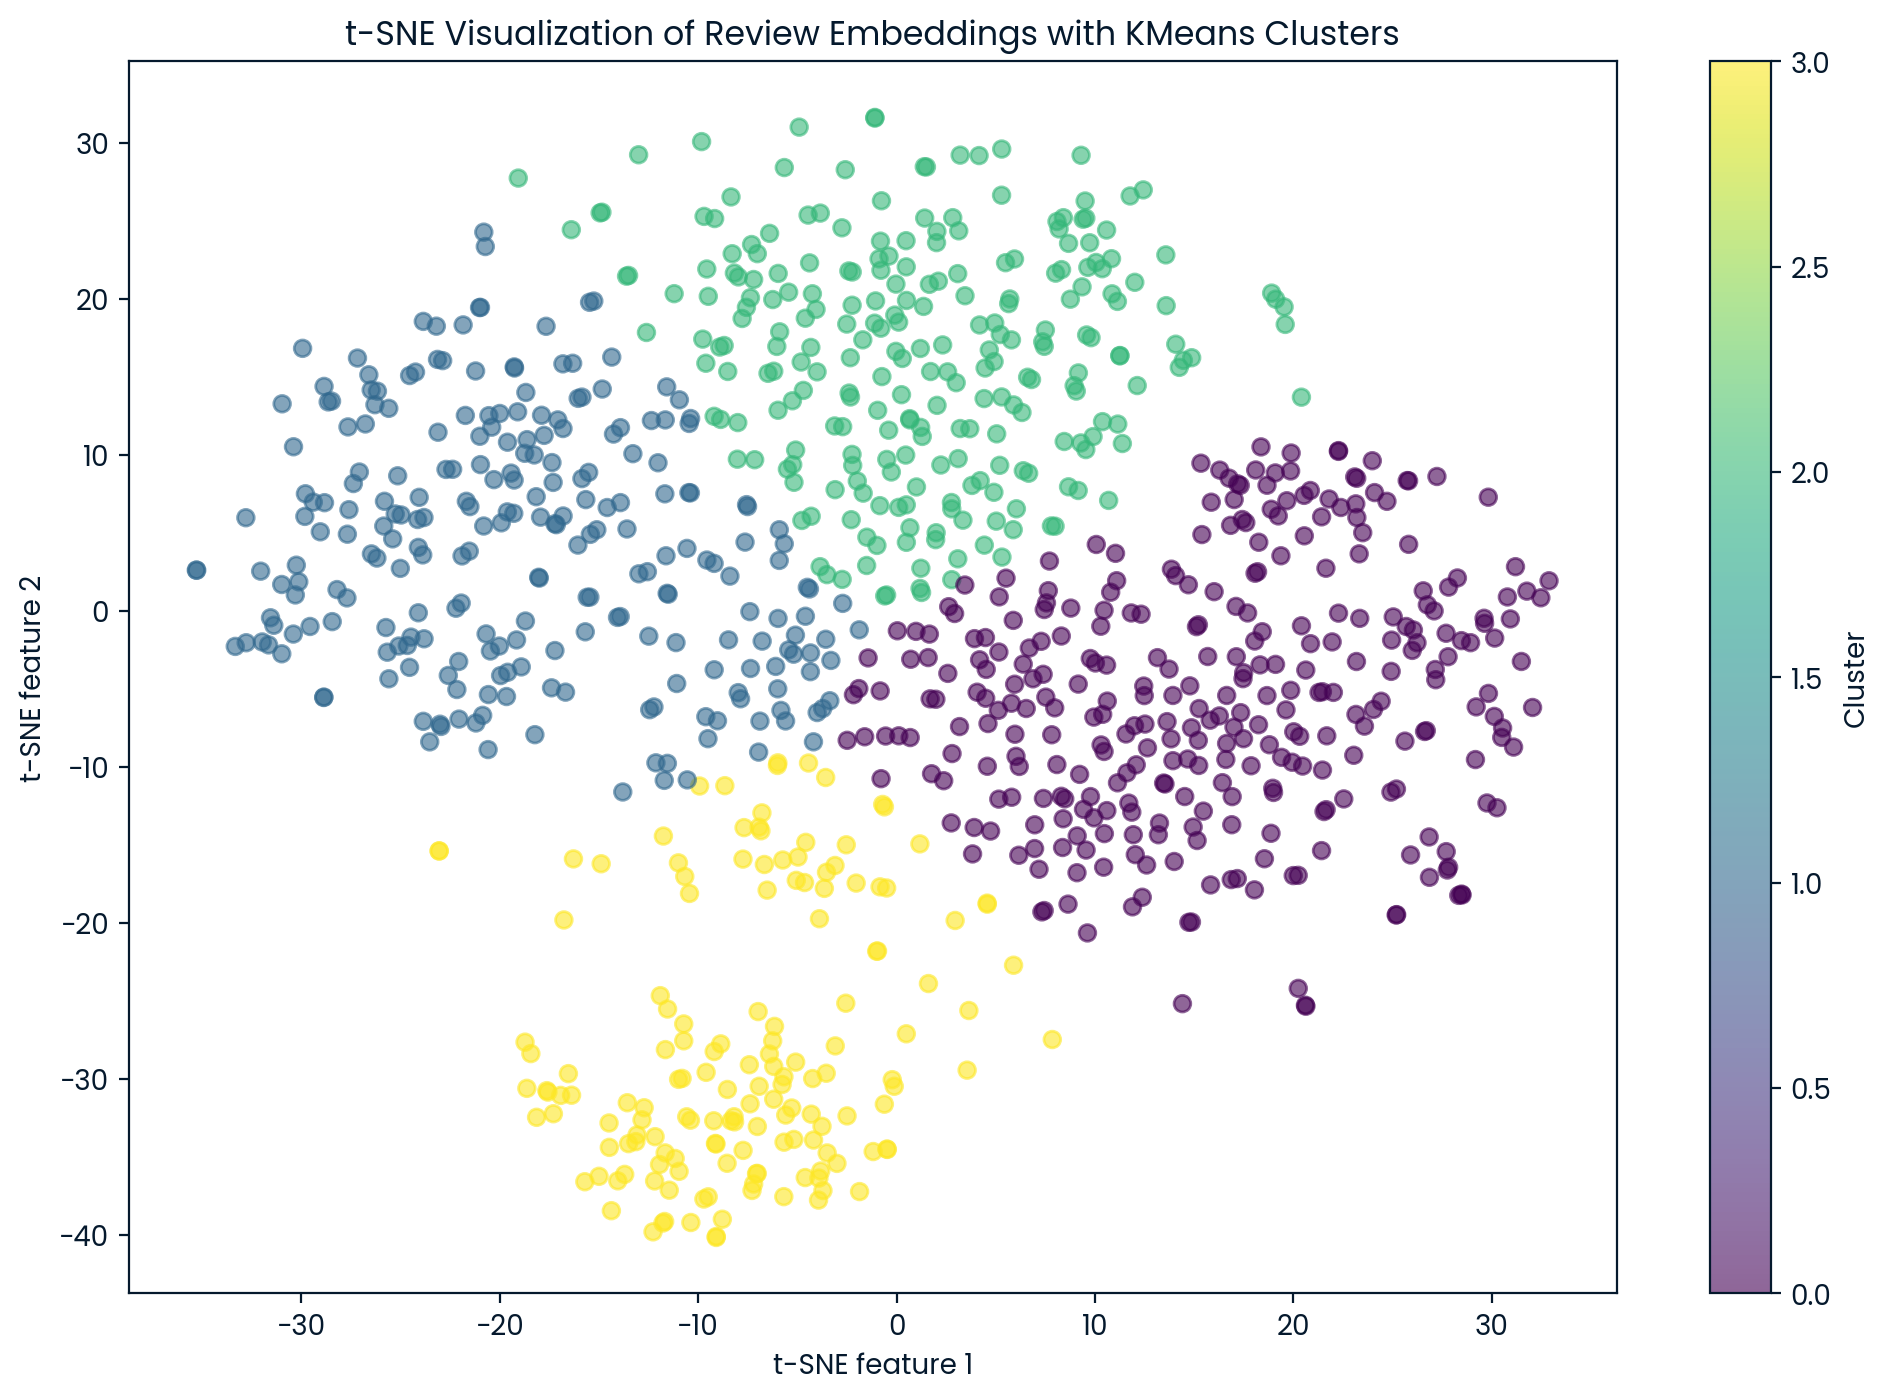

In [37]:
from sklearn.cluster import KMeans

# Apply KMeans to cluster the 2D embeddings
def cluster_embeddings(embeddings_2d, n_clusters=4):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(embeddings_2d)
    return cluster_labels

# Generate cluster labels
cluster_labels = cluster_embeddings(embeddings_2d, n_clusters=4)

# Updated plot with cluster coloring
def plot_tsne_with_clusters(tsne_results, cluster_labels):
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(
        tsne_results[:, 0], tsne_results[:, 1],
        c=cluster_labels, cmap='viridis', alpha=0.6
    )
    plt.colorbar(scatter, label='Cluster')
    plt.title("t-SNE Visualization of Review Embeddings with KMeans Clusters")
    plt.xlabel("t-SNE feature 1")
    plt.ylabel("t-SNE feature 2")
    plt.show()

# Call updated plotting function
plot_tsne_with_clusters(embeddings_2d, cluster_labels)

---

## 🧾 Conclusion: From Raw Reviews to Real Insights

This project was an exciting deep dive into transforming raw, unstructured customer reviews into meaningful, visual, and actionable insights using the power of **language embeddings** and **semantic search**.

By embedding review texts with OpenAI’s `text-embedding-ada-002` model, we went beyond basic keyword analysis to understand the **semantic essence** of what customers were really saying. We:

- **Visualized hidden patterns** in review content using **t-SNE**
- **Automatically categorized** reviews into relevant themes (Quality, Fit, Style, Comfort)
- **Enabled semantic search** with **ChromaDB**, allowing us to retrieve similar reviews based on meaning, not just matching words
- **Uncovered latent clusters** using **KMeans**, revealing deeper groupings within the feedback

All of this was done in Python, leveraging a mix of **NLP**, **machine learning**, **vector databases**, and **data visualization** — a powerful stack for modern customer experience analytics.

This project not only reflects technical fluency but also shows how data science can bridge the gap between business needs and user experience. Thanks for following along — let’s keep turning data into value! 🔍📈
